In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt



In [8]:
# === Device configuration ===
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [7]:
# === Define device ===
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [30]:
class ImageClassificationBase(nn.Module):

    def training_step(self, batch):
        images, labels = batch
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss

    def validation_step(self, batch):
        images, labels = batch
        out = self(images)                   # Generate prediction
        loss = F.cross_entropy(out, labels)  # Calculate loss
        acc = accuracy(out, labels)          # Calculate accuracy
        return {"val_loss": loss.detach(), "val_accuracy": acc}

    def validation_epoch_end(self, outputs):
        batch_losses = [x["val_loss"] for x in outputs]
        batch_accuracy = [x["val_accuracy"] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()       # Combine loss
        epoch_accuracy = torch.stack(batch_accuracy).mean()
        return {"val_loss": epoch_loss, "val_accuracy": epoch_accuracy} # Combine accuracies

    def epoch_end(self, epoch, result):
        print("Epoch [{}], last_lr: {:.5f}, train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['lrs'][-1], result['train_loss'], result['val_loss'], result['val_accuracy']))


# Architecture for training

# convolution block with BatchNormalization
def ConvBlock(in_channels, out_channels, pool=False):
    layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
             nn.BatchNorm2d(out_channels),
             nn.ReLU(inplace=True)]
    if pool:
        layers.append(nn.MaxPool2d(4))
    return nn.Sequential(*layers)


# resnet architecture
class ResNet9(ImageClassificationBase):
    def __init__(self, in_channels, num_diseases):
        super().__init__()

        self.conv1 = ConvBlock(in_channels, 64)
        self.conv2 = ConvBlock(64, 128, pool=True) # out_dim : 128 x 64 x 64
        self.res1 = nn.Sequential(ConvBlock(128, 128), ConvBlock(128, 128))

        self.conv3 = ConvBlock(128, 256, pool=True) # out_dim : 256 x 16 x 16
        self.conv4 = ConvBlock(256, 512, pool=True) # out_dim : 512 x 4 x 44
        self.res2 = nn.Sequential(ConvBlock(512, 512), ConvBlock(512, 512))

        self.classifier = nn.Sequential(nn.MaxPool2d(4),
                                       nn.Flatten(),
                                       nn.Linear(512, num_diseases))

    def forward(self, xb): # xb is the loaded batch
        out = self.conv1(xb)
        out = self.conv2(out)
        out = self.res1(out) + out
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.res2(out) + out
        out = self.classifier(out)
        return out

In [23]:
# === Class labels (your mapping) ===
class_names = [
    'Apple___Apple_scab', 'Apple___Black_rot', 'Apple___Cedar_apple_rust',
    'Apple___healthy', 'Blueberry___healthy', 'Cherry_(including_sour)___Powdery_mildew',
    'Cherry_(including_sour)___healthy', 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot',
    'Corn_(maize)___Common_rust_', 'Corn_(maize)___Northern_Leaf_Blight',
    'Corn_(maize)___healthy', 'Grape___Black_rot', 'Grape___Esca_(Black_Measles)',
    'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)', 'Grape___healthy',
    'Orange___Haunglongbing_(Citrus_greening)', 'Peach___Bacterial_spot',
    'Peach___healthy', 'Pepper,_bell___Bacterial_spot', 'Pepper,_bell___healthy',
    'Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy',
    'Raspberry___healthy', 'Soybean___healthy', 'Squash___Powdery_mildew',
    'Strawberry___Leaf_scorch', 'Strawberry___healthy', 'Tomato___Bacterial_spot',
    'Tomato___Early_blight', 'Tomato___Late_blight', 'Tomato___Leaf_Mold',
    'Tomato___Septoria_leaf_spot', 'Tomato___Spider_mites Two-spotted_spider_mite',
    'Tomato___Target_Spot', 'Tomato___Tomato_Yellow_Leaf_Curl_Virus',
    'Tomato___Tomato_mosaic_virus', 'Tomato___healthy'
]

In [31]:
model = ResNet9(in_channels=3, num_diseases=len(class_names))
model.load_state_dict(torch.load("D:/Model/plant-disease-model.pth", map_location=device))
model.to(device)
model.eval()


C:\Users\JASH DESAI\AppData\Local\Temp\ipykernel_38144\405332937.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("D:/Model/plant-disease

ResNet9(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  )
  (res1): Sequential(
    (0): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=Tr

In [32]:
# === Transform same as used in training ===
transform = transforms.ToTensor()

In [33]:
# === Predict Function ===
def predict_image(image_path, model, class_names):
    image = Image.open(image_path).convert('RGB')
    img_tensor = transform(image).unsqueeze(0).to(device)

    with torch.no_grad():
        output = model(img_tensor)
        _, predicted = torch.max(output, dim=1)
        predicted_class = class_names[predicted.item()]

    # Visual + prediction
    plt.imshow(image)
    plt.axis('off')
    plt.title(f"Predicted: {predicted_class}")
    plt.show()

    return predicted_class

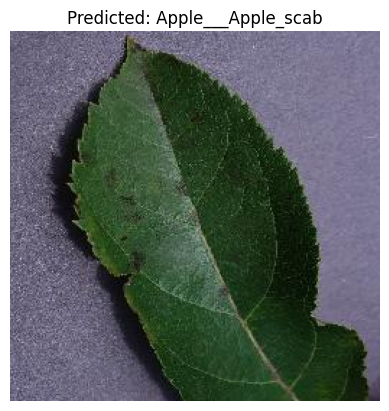

Predicted Label: Apple___Apple_scab


In [ ]:
# === Example Usage ===
image_path = r'D:\Model\Kaggle\New Plant Diseases Dataset(Augmented)\New Plant Diseases Dataset(Augmented)\train\Apple___Apple_scab\0a14783a-838a-4d4f-a671-ff98011714c6___FREC_Scab 3288.JPG'  # Replace with your actual image path
predicted = predict_image(image_path, model, class_names)
print("Predicted Label:", predicted)